In [9]:
# imports 
import time
import os, sys, glob
import cv2
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm.auto import tqdm
from PIL import Image, ImageFile
from importlib import reload
from torch.utils.data import DataLoader
from IPython.display import clear_output

# custom imports
sys.path.append('../')

from utils.GetLowestGPU import GetLowestGPU
from utils.GetLR import get_lr
import utils.BuildWNet as BuildWNet
import utils.WNetTileGenerator as TG
import utils.Loss as Loss
import utils.Train as Train

# get device
device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 00422MiB / 40537MiB
  1  | 00003MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 04518MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:1
---------------------------


# Load And Visualize Data

In [10]:
# define paths
image_path = '../data/train/images_by_pod/'

# load images and masks into list
# load image data
image_names = glob.glob(image_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

n_pad = 128

images = []
# VISUALIZE
for img_name in tqdm(image_names):
    # load image
    image = np.array(Image.open(image_path + img_name))
    image = (image[:, :, :3] / 255.0) # normalize image
    image = np.pad(image, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'edge') # pad image w/ values on edge
    images.append(image)




  0%|          | 0/164 [00:00<?, ?it/s]

Plotting training examples...


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/imgwarp.cpp:2729: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'warpAffine'


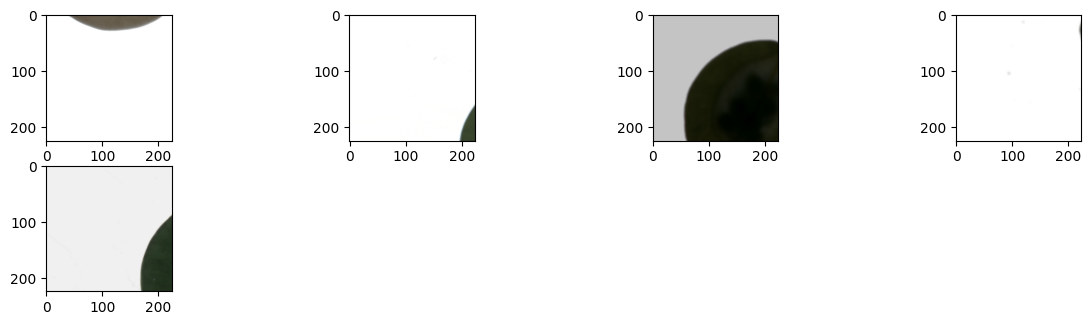

In [13]:
# separate images into train/val set w/ 80-20 split
train_prop = 0.8

#create train/val splits by image
p = np.random.permutation(len(images))
train_idx = p[:int(train_prop*len(images))]
val_idx = p[int(train_prop*len(images)):]

reload(TG)
# instantiate tile generator
train_generator = TG.TileGenerator(images = [images[i] for i in train_idx],
                                   tile_size = 224,
                                   split = 'train',
                                   n_pad = n_pad
                                   )

val_generator = TG.TileGenerator(images = [images[i] for i in val_idx],
                                 tile_size = 224,
                                 split = 'val',
                                 n_pad = n_pad)

#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(train_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    img, out = train_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()
    
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(img, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(val_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    img, out = val_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()

    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(img, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

# Create Model

In [43]:
# instantiate w-net and optimizer
reload(BuildWNet)
model = BuildWNet.WNet(k = 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train Model

In [44]:
# options

# log options
log_path = '../logs/log.csv'
chckpnt_path = '../checkpoints/checkpoint_{0}.pt'

# lr options
warmup_iters = 1000
lr_decay_iters = 90000
max_lr = 1e-3
min_lr = 1e-5
max_iters = 150000

In [47]:
train_generator[1]

error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/imgwarp.cpp:2729: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'warpAffine'


In [45]:
reload(Train)
Train.train_model(model = model,
                  optimizer = optimizer,
                  train_generator = train_generator,
                  val_generator = val_generator,
                  log_path = log_path,
                  chckpnt_path=chckpnt_path,
                  device = device,)

-------------
Iteration: 0
-------------


 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/DGX01/Personal/krusepi/codebase/projects/phenotyping/PennycressWNet/notebooks/../utils/WNetTileGenerator.py", line 80, in __getitem__
    augmented = self.augment(image=tile)
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/albumentations/core/composition.py", line 210, in __call__
    data = t(**data)
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 118, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 131, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/albumentations/augmentations/geometric/transforms.py", line 657, in apply
    return F.warp_affine(
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/albumentations/augmentations/utils.py", line 122, in wrapped_function
    result = func(img, *args, **kwargs)
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/albumentations/augmentations/geometric/functional.py", line 560, in warp_affine
    tmp = warp_fn(image)
  File "/mnt/DGX01/Personal/krusepi/.venv/lib/python3.8/site-packages/albumentations/augmentations/utils.py", line 208, in __process_fn
    img = process_fn(img, **kwargs)
cv2.error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/imgwarp.cpp:2729: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'warpAffine'

